In [1]:
import keras
import matplotlib.pyplot as plt

from keras.layers import Dense
from keras.models import Sequential
from centroid_network.utils import *
from centroid_network.CentroidNetwork import CentroidNetwork
from sklearn.model_selection import train_test_split


# 1. Load the original MNIST dataset. Divide it into train and test datasets. Separate labels.

In [2]:
dataset = read_dataset("../datasets/mnist.csv")
dataset = normalize_input(dataset)

dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=42)
x_train, y_train = separate_labels_from_dataset(dataset_train)
x_test, y_test = separate_labels_from_dataset(dataset_test)

print("Training data shape: ", x_train.shape)
print("Test data shape", x_test.shape)

Training data shape:  (55999, 784)
Test data shape (14000, 784)


# 2. Centroid network training and feeding both datasets (train and test).

Configure logger used by the centroid network.

In [3]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler("../output/hybrid_network.log"),
        logging.StreamHandler()
    ]
)

In [4]:
CN = CentroidNetwork()
CN.append_layer(M=100)
CN.multiprocess_train(X=dataset_train)
after_network_train = CN.multiprocess_feed_forward(dataset_train)
after_network_test = CN.multiprocess_feed_forward(dataset_test)

2020-10-29 14:00:48,714 [INFO] Layer with 100 centroids per class appended to network.
2020-10-29 14:00:48,715 [INFO] Training the network (calculating centroids)...
2020-10-29 14:05:33,905 [INFO] Feeding data through network...
2020-10-29 14:23:21,750 [INFO] Feeding data through network...


# 3. Create method for creating, training and evaluation NN architecture (using keras).

In [5]:
def train_and_evaluate_keras_model(x_train, y_train, x_test, y_test, image_size: int = 0):
    num_classes = 10
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    print("First 5 training labels as one-hot encoded vectors:\n", y_train[:5])

    model = Sequential()

    model.add(Dense(units=32, activation='sigmoid', input_shape=(image_size,)))
    model.add(Dense(units=10, activation='softmax'))
    model.summary()

    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=False, validation_split=.1)
    loss, accuracy = model.evaluate(x_test, y_test, verbose=False)

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.show()

    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

# 4. Train and evaluate keras model using original data (no centroid network)

First 5 training labels as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.196
Test accuracy: 0.944


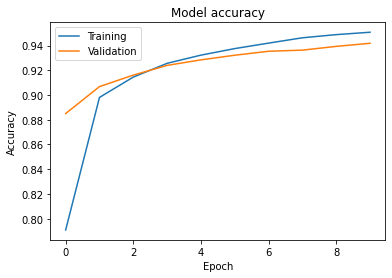

In [6]:
train_and_evaluate_keras_model(x_train=x_train,
                               y_train=y_train,
                               x_test=x_test,
                               y_test=y_test,
                               image_size=784)

# 5. Train and evaluate keras model using data feeded through centroid network

First 5 training labels as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 3,562
Trainable params: 3,562
Non-trainable params: 0
_________________________________________________________________
Test loss: 2.3
Test accuracy: 0.116


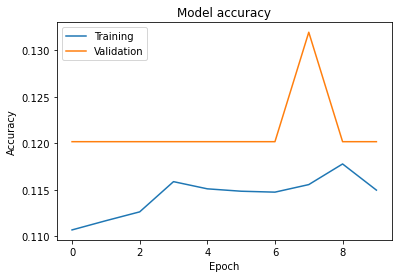

In [7]:
x_train, y_train = separate_labels_from_dataset(after_network_train)
x_test, y_test = separate_labels_from_dataset(after_network_test)

train_and_evaluate_keras_model(x_train=x_train,
                               y_train=y_train,
                               x_test=x_test,
                               y_test=y_test,
                               image_size=100)